# 2 Use pretrained BERT for sentiment analysis

For the predictive model I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html).

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn import metrics


sns.set(font_scale=2)


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels= 5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

plt.style.use('seaborn-white')
%matplotlib inline

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The random number seed for shuffling the training set should be used for maintaining shuffling in the case of Python runtime not keeping it's state between epochs (e.g. [Google Colab](https://colab.research.google.com)):

In [110]:
seed_batching = 123

In [111]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


## 2.1 Creating of Training and Validation sets
The dataset is splitted into train (80% samples) and validation (20%) sets: 

Loading clean and deduplicated dataset (**only first 10000 rows, for actual training remove the limitation**):

In [188]:
#df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip", compression="zip", index_col=0, nrows=10000)
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip", compression="zip", index_col=0)

In [189]:
df_dedup.tail(5)

,Text,Summary,Score,HelpfulnessNumerator,HelpfulnessDenominator
394998,these are sooooooooooooooooooooooooo delicious...,"yummy. yummy, yummy!",5,0,3
394999,this is a for the price of review because p...,pure chocolate mallomars cookies,4,0,0
395000,this would be a great coffee drink to grab out...,soso espresso style coffee drink,3,1,2
395001,"earths best infant formula soy iron,ounce is a...",earths best soy baby formula,5,0,0
395002,taste. i was expecting it to taste pretty clos...,ehh okay i guess.,2,1,1


In [190]:
df_train = df_dedup.sample(frac=0.8,random_state=123)
df_test = df_dedup.drop(train.index)

In [191]:
def convert_df_to_twocolumn_labeldecrease(input_df, data_col_name, label_col_name):
    out_df = input_df[[data_col_name, label_col_name]]
    out_df = out_df.rename(columns={data_col_name: "DATA_COLUMN", label_col_name: "LABEL_COLUMN"})
    out_df["LABEL_COLUMN"] = out_df["LABEL_COLUMN"] - 1
    return(out_df)

In [192]:
train = convert_df_to_twocolumn_labeldecrease(df_train, "Text", "Score")
test = convert_df_to_twocolumn_labeldecrease(df_test, "Text", "Score")

In [193]:
train.tail()

,DATA_COLUMN,LABEL_COLUMN
20293,best price out there! i have been buying organ...,4
30395,dogs loved them but then i found out theyre fr...,0
234339,nido is neato really a great tasting product a...,4
49563,green mountain coffee has my wife pegged. this...,3
289396,these are the perfect size for training but th...,2


At the first step a model predicting review score based on the review text will be created.
For training of the BERT model the dataset samples should be converted to the *InputExample* objects, containing

- *guid* - unique id for the example (not used)
- *text_a* (string) - the untokenized text of the first sequence
- *text_b* (optional, string) - the untokenized text of the second sequence (not used)
- label (optional, int) - The label of the example

and assembled to the TensorFlow datasets *train_data* and *validation_data*:

In [113]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True, # Add [CLS] and [SEP]
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [114]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(buffer_size=1000, seed=seed_trainset).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 2.2 Treating sample imbalance

The classes in our dataset are highly imbalanced. Rating 5(Class 4) is over 60 percent of all examples with the other classes hovering around 10 percent. In order to mitigate the impact of an unbalanced training set the [*SparseCategoricalFocalLoss*](https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.SparseCategoricalFocalLoss.html#focal_loss.SparseCategoricalFocalLoss) loss function is used. This function generalizes multiclass softmax cross-entropy by introducing a hyperparameter called the focusing parameter that allows hard-to-classify examples to be penalized more heavily relative to easy-to-classify examples.

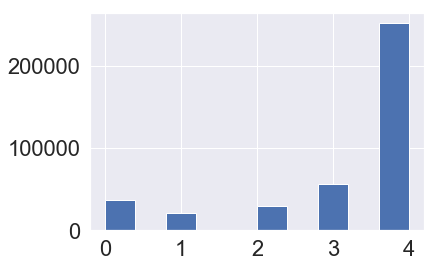

In [115]:
plt.hist(text_labels["LABEL_COLUMN"]);

In [31]:
%run SparseCategoricalFocalLoss.py

For the proper use of the *SparseCategoricalFocalLoss* loss function the *weights*, or classes distribution in the training set should be calculated:

In [29]:
num_classes = text_labels["LABEL_COLUMN"].nunique()
classes_dist = []
n_of_class = text_labels.groupby("LABEL_COLUMN")
for i in range(num_classes):
    classes_dist.append(len(n_of_class.groups[i])/len(text_labels))
weights = tf.convert_to_tensor(classes_dist, dtype=tf.float32)

## 2.3 Training the model
The actual model has been trained on the [Google Colab](https://colab.research.google.com) free runtime. In order to feed the model with different training sets across the epochs *seed_trainset* random seed should be changed. The variation of *learning_rate* parameter between 1e-5 and 4e-5 as well as *gamma* power from 1 to 4 did not affected validation accuracy significantly. The *amazon_my_trained_FL_G_k7e12ac78L03vac75VL04g2lr4* model was trained within 12 epochs, 11 epochs with 2000 steps and the last epoch with 7000 steps (about 7% of original training set used for the training). The training step time for the given batch size was about 400 ms for P100 GPU and 800 ms for T4 GPU. The validation set accuracy along the epochs was around 75%.

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights, from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [35]:
#model.fit(train_data, epochs=1, validation_data=validation_data)

In [36]:
#model.load_weights("./amazon_my_trained_FL_G_k7e12ac78L03vac75VL04g2lr4")

## 2.4 Outlook

The model accuracy can be enhanced following ways:

- Training on cloud, making the model possible to see all the training examples at least once during the training
- Use human-assisted filtering, namely *HelpfulnessNumerator* and	*HelpfulnessDenominator* dataset columns, constructing DNN classifier using last BERT layer (of size 768), *HelpfulnessNumerator* and	*HelpfulnessDenominator* as an input.